# **IMPORT LIBS**

In [37]:
import warnings

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam


import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout,Conv1D,Flatten,Bidirectional,BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

import keras.backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from skimage.transform import rotate, shear, zoom
#from imgaug import augmenters as iaa

warnings.filterwarnings('ignore')

In [38]:
# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, os.pardir))

datasetUAH_dir = os.path.join(root_dir, 'datasets', 'UAH-DRIVESET-v1', 'UAH-Processed')

print(f'Root directory: {root_dir}')
print(f'Dataset directory: {datasetUAH_dir}')

Root directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification
Dataset directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification\datasets\UAH-DRIVESET-v1\UAH-Processed


# **AUX FUNCTIONS**

In [39]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  
  filename = 'runtime_saves/' + filename
    
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def has_one(data):
  """
  This function receives a numpy array and returns a new array
  with 1 if the correspondent row of input array has at least one cellule with 1.
  In other case the cellule is 0.

  Args:
      data: A numpy array of shape (n, 12) with 0 or 1 values in each cell.

  Returns:
      A numpy array of shape (n, 1) with 1s where the corresponding row in data has at least one 1, and 0s otherwise.
  """
  # We sum each row, and any value greater than zero indicates at least one 1 in that row
  return np.sum(data, axis=1)[:, np.newaxis] > 0

# **IMPORT DATA**

In [40]:
# Empty dataframe necessary columns
df = pd.DataFrame(columns=['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 'latitude', 'longitude'])


acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

# Loop through all the files in the dataset directory
for root, dirs, files in os.walk(datasetUAH_dir):
    for file in files:
        if file.endswith(".csv"):
            df_aux = pd.read_csv(os.path.join(root, file))
            
            acelX = pd.concat([acelX, df_aux['accelerometerXAxis']])
            acelY = pd.concat([acelY, df_aux['accelerometerYAxis']])
            acelZ = pd.concat([acelZ, df_aux['accelerometerZAxis']])
            gyrX = pd.concat([gyrX, df_aux['gyroscopeXAxis']])
            gyrY = pd.concat([gyrY, df_aux['gyroscopeYAxis']])
            gyrZ = pd.concat([gyrZ, df_aux['gyroscopeZAxis']])
            latitude = pd.concat([latitude, df_aux['latitude']])
            longitude = pd.concat([longitude, df_aux['longitude']])
            
            print(f'{file} added to the dataframe')

20151110175712-16km-D1-NORMAL1-SECONDARY.csv added to the dataframe
20151110180824-16km-D1-NORMAL2-SECONDARY.csv added to the dataframe
20151111123124-25km-D1-NORMAL-MOTORWAY.csv added to the dataframe
20151111125233-24km-D1-AGGRESSIVE-MOTORWAY.csv added to the dataframe
20151111132348-25km-D1-DROWSY-MOTORWAY.csv added to the dataframe
20151111134545-16km-D1-AGGRESSIVE-SECONDARY.csv added to the dataframe
20151111135612-13km-D1-DROWSY-SECONDARY.csv added to the dataframe
20151120131714-26km-D2-NORMAL-MOTORWAY.csv added to the dataframe
20151120133502-26km-D2-AGGRESSIVE-MOTORWAY.csv added to the dataframe
20151120135152-25km-D2-DROWSY-MOTORWAY.csv added to the dataframe
20151120160904-16km-D2-NORMAL1-SECONDARY.csv added to the dataframe
20151120162105-17km-D2-NORMAL2-SECONDARY.csv added to the dataframe
20151120163350-16km-D2-AGGRESSIVE-SECONDARY.csv added to the dataframe
20151120164606-16km-D2-DROWSY-SECONDARY.csv added to the dataframe
20151126110502-26km-D3-NORMAL-MOTORWAY.csv added

In [41]:
print(df['accelerometerXAxis'].describe())
print(df['accelerometerYAxis'].describe())
print(df['accelerometerZAxis'].describe())
print(df['gyroscopeXAxis'].describe())
print(df['gyroscopeYAxis'].describe())
print(df['gyroscopeZAxis'].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: accelerometerXAxis, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: accelerometerYAxis, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: accelerometerZAxis, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: gyroscopeXAxis, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: gyroscopeYAxis, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: gyroscopeZAxis, dtype: object


# **SEPARATE DATA BY MANOVER**

In [42]:
turnRightX, turnLeftX = separate_positives_negatives(acelX)

accelY, breakY = separate_positives_negatives(acelY)

positiveZ, negativeZ = separate_positives_negatives(acelZ)

gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)

In [43]:
turnRightX.shape

(306303,)

# **CLASSIFICATION BASED ON NOT NORMALIZED VALUES**

In [44]:
#x1 = np.array(list(zip(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ, gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)))

#y = y_classification(x1, 0.25)
#print (np.sum(y, axis=0))
#np.savetxt("Y.csv", y, delimiter=',', fmt='%.0i')

# **NORMALIZE DATA**

In [45]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

# **CREATE AN ARRAY WITH ALL DATA**

In [46]:
x = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

In [47]:
x.shape

(306303, 12)

In [48]:
y = y_classification(x, 0.3)
print (np.sum(y, axis=0))

filename = 'runtime_saves/' + 'Y.csv'
print(y)

np.savetxt(filename, y, delimiter=',', fmt='%.0i')

[   224   1810   1464   7884   2918    390 306303 306303   4944   8828
  72830  80789]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]]


# **SHOW MANOVERS ON GOOLGE MAP**

In [49]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

# **PLOT MANOVERS**

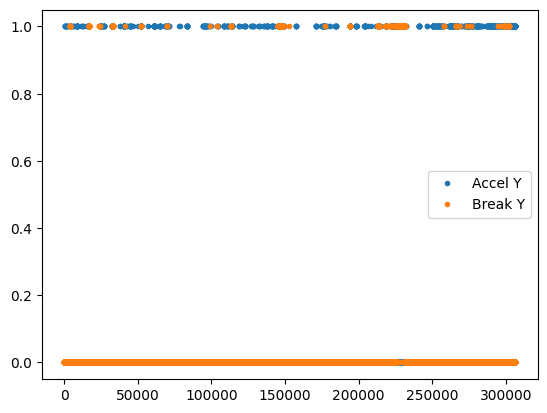

In [50]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# **SEPARATE DATA IN TRAIN AND TEST**

In [51]:
x_train, x_test = split_train_test(x, test_size=0.2)

y_train, y_test = split_train_test(y, test_size=0.2)

# **CREATE THE INPUT TENSORES DATA**

In [52]:
train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

print(train.shape)
print(test.shape)

np.savetxt("runtime_saves/train&test/x_train.csv", x_train, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/x_test.csv", x_test, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/y_train.csv", y_train, delimiter=',', fmt='%.0i')
np.savetxt("runtime_saves/train&test/y_test.csv", y_test, delimiter=',', fmt='%.0i')

np.savetxt("runtime_saves/train&test/train.csv", train.reshape(train.shape[0], train.shape[2]), delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/test.csv", test.reshape(test.shape[0], test.shape[2]), delimiter=',', fmt='%.9f')

(245042, 1, 12)
(61261, 1, 12)


# **CREATE THE MODEL**

In [53]:
# Clear session
K.clear_session()

# Model configuration
dropout1 = 0.5
dropout2 = 0.2
dropout3 = 0.1
initial_learning_rate = 0.001

# Define the model
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(train.shape[1], train.shape[2])))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(dropout1))
model_lstm.add(Bidirectional(LSTM(64, return_sequences=False)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(dropout2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(dropout3))
model_lstm.add(Dense(12, activation='sigmoid'))



# Compile the model
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# **TRAIN THE MODEL**

In [55]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.0000)
model_checkpoint = ModelCheckpoint('best_models/best_model_BILSTM.keras', monitor='val_loss', save_best_only=True)



# Train the model
model_lstm_output = model_lstm.fit(train, y_train, epochs=10,  batch_size=1024, callbacks=[early_stopping,model_checkpoint,reduce_lr], validation_data=(test, y_test))

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2559 - loss: 0.0228 - val_accuracy: 0.1442 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2424 - loss: 0.0129 - val_accuracy: 0.2996 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2582 - loss: 0.0097 - val_accuracy: 0.3867 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2686 - loss: 0.0082 - val_accuracy: 0.4464 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2864 - loss: 0.0068 - val_accuracy: 0.4256 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 6/10
107/240 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2789 - loss: 0.0066

KeyboardInterrupt: 

# **SHOW THE RESULTS**

KeyError: 'val_loss'

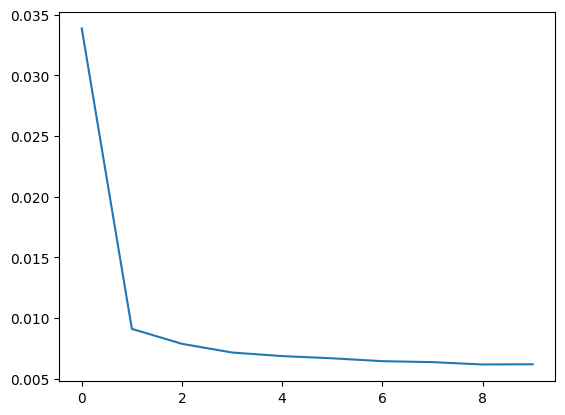

In [ ]:
plt.plot(model_lstm_output.history['loss'])
plt.plot(model_lstm_output.history['val_loss'])
plt.title('Historico de train')
plt.xlabel('Epocas de train')
plt.ylabel('Função custo')
plt.legend(['Erro train', 'Erro test'])
plt.show()

In [ ]:
accuracy = model_lstm.evaluate(test, y_test)[1]  # Assuming accuracy is the second metric
print('Test Accuracy:', accuracy)

1915/1915 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9744 - loss: 0.0049
Test Accuracy: 0.958505392074585


# **TEST THE NETWORK**

In [ ]:
loss, accurary = model_lstm.evaluate(test, y_test, batch_size=16)
print('Test loss/accurary:', loss, accurary)


3829/3829 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9744 - loss: 0.0049
Test loss/accurary: 0.005052972584962845 0.958505392074585


## **Confusion Matrix**

7658/7658 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


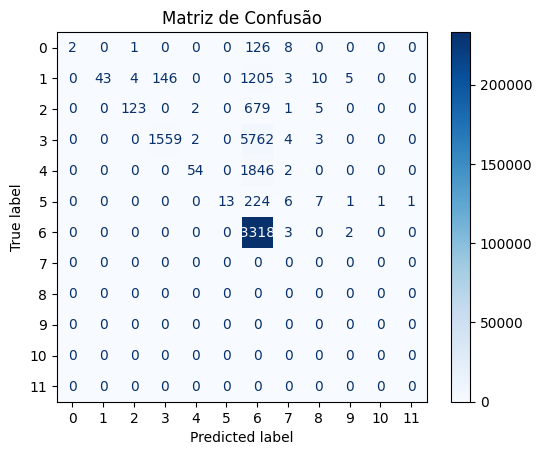

{'accuracy': [0.3851339817047119, 0.49436014890670776, 0.622925877571106, 0.7165751457214355, 0.7332906126976013, 0.745182454586029, 0.8236016631126404, 0.8227201700210571, 0.8602076172828674, 0.8707772493362427], 'loss': [0.0338653028011322, 0.009111548773944378, 0.007880344055593014, 0.007163382600992918, 0.006868887227028608, 0.00668695755302906, 0.0064515890553593636, 0.006371731404215097, 0.006178255192935467, 0.0061962497420609]}


In [ ]:
y_train_classes = np.argmax(y_train, axis=1)

y_pred = model_lstm.predict(train)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_train_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

print(model_lstm_output.history)

In [ ]:
test[0]
test.shape

In [ ]:
i = 0
for i in range(100):
    a = x_test[i]
    b = a.reshape(1, 1, 12)

    # Make predictions on new data
    prediction = model_lstm.predict(b)
    #predicted_class = label_encoder.inverse_transform(prediction)[0]

    np.round(prediction, decimals=1, out=prediction)
    np.round(x_test[i], decimals=1, out=x_test[i])
    #print("Value:", newArray[i + start])
    if (np.sum(y_test[i]) > 0):
      print("X [:", x_test[i])
      print("Y [:", y_test[i])
      print("PC:", prediction)
      print (i)
    i = 1 + 1
#PREDICTIONS WITH COLAB MODEL
#prediction = model.predict(teste)
#print("Predicted class:", prediction)
#print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
X [: [0.  0.1 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
Y [: [0 0 0 0 0 0 1 1 0 0 0 0]
PC: [[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
X [: [0.  0.1 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
Y [: [0 0 0 0 0 0 1 1 0 0 0 0]
PC: [[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
X [: [0.  0.1 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
Y [: [0 0 0 0 0 0 1 1 0 0 0 0]
PC: [[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
X [: [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
Y [: [0 0 0 0 0 0 1 1 0 0 0 0]
PC: [[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
X [: [0.1 0.  0.  0.1 0.  0.  0.  0.5 0.  0.  0.  0. ]
Y [: [0 0 0 0 0 0 1 1 0 0 0 0]
PC: [[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
X [: [0.  0.  0.  0.  0.  0.1 0.  0.5 0.  0.  0.  0. ]
Y [: [0 0 0 0 0 0 1 1 0 0 0 0]
PC: [[0. 0. 0. 0. 0. 0. 1.

In [ ]:
test_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
test_value = test_value.reshape(1, 1, 12)

# Make predictions on new data
prediction = model_lstm.predict(test_value)
np.round(prediction, decimals=2, out=prediction)

print("Value    :", test_value[0][0])
print("Predicted:", prediction[0])

# **SAVE THE MODEL**

In [ ]:
import os
import datetime

model_name = 'lstm_model_CONV' + datetime.datetime.now().strftime("%Y-%m-%d %HH%Mm%Ss") + '.h5'

# Save the model in runtime_saves/models folder
model_lstm.save(os.path.join(".", 'runtime_saves', 'models', model_name))

In [ ]:
# model sumary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,798 (116.40 KB)

 Trainable params: 9,932 (38.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,866 (77.61 KB)